In [2]:
# import pandas as pd
import numpy as np
import os
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import time
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import pandas as pd

ModuleNotFoundError: No module named 'pandas'

In [8]:
cfw_dict = {
    'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7
}

opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

In [9]:
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

def display_images(imgs,classes,row=1,col=2,w=32,h=32):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

def load_data(dir_path):
    image_list = []
    y_list = []
    label_dict = cfw_dict
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue
    image_list = np.array(image_list)
    y_list = np.array(y_list)
    # print("Dataset shape:",image_list.shape)
    # print("Label shape:",y_list.shape)
    # print(image_list[0])
    return image_list,y_list

In [10]:
def reshape_to_X(image_list):
    
    n,rows,cols,channel = image_list.shape 
    m = rows*cols*channel # -->size of each feature vector
    
    X = image_list.reshape(n,m)
    return X

In [11]:
# standardizes data into 0 mean and 1 variance
def standardize_data(X):
    for f in range(X.shape[1]):
        X[:,f] = (X[:,f]-np.mean(X[:,f]))/np.std(X[:,f])
    return X

In [12]:
# returns the set of eigenvalues and eigenvectors of A in sorted fashion
def getEigen(A,iterations=10):
    Ak = np.copy(A)
    n = A.shape[0]
    QQ = np.eye(n)
    for k in range(iterations):
        Q, R = np.linalg.qr(Ak)
        Ak = R @ Q
        QQ = QQ @ Q
            
    values = np.diag(Ak)
    vectors = QQ
    
    # sorting the eigenvectors and eigenvalues based on dec eigenvalues
    sorted_ind = np.argsort(-values) # -ve sign for decreasing order of eigenvalues
    sorted_values = values[sorted_ind]
    sorted_vectors = vectors[sorted_ind]

    return sorted_values, sorted_vectors

In [76]:
# loading the dataset in X and its labels in y
dirpath = 'SMAI-PCAdataset/IIIT-CFW/'
X,y = load_data(dirpath)
print('Initial shape : ',X.shape)
X = reshape_to_X(X)
print('Resized shape : ',X.shape)

Initial shape :  (672, 32, 32, 3)
Resized shape :  (672, 3072)


In [77]:
# finding accuracy for original number of dimensions (3072)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=32)

t_start = time.time()
model = LogisticRegression(max_iter=2000)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
t_end = time.time()
print('Performance for Number of dimensions = 3072')
print(classification_report(y_test,y_pred))
accuracy_original = accuracy_score(y_test, y_pred)
print('\n\nAccuracy : ',accuracy_original)
print('Inference Time : ',np.round(t_end-t_start,2),' sec')


Performance for Number of dimensions = 3072
              precision    recall  f1-score   support

           0       0.21      0.75      0.33         4
           1       0.75      0.40      0.52        15
           2       0.59      0.59      0.59        17
           3       0.38      0.59      0.47        17
           4       0.60      0.47      0.53        19
           5       0.78      0.61      0.68        23
           6       0.78      0.88      0.82        16
           7       0.74      0.58      0.65        24

    accuracy                           0.59       135
   macro avg       0.60      0.61      0.57       135
weighted avg       0.65      0.59      0.60       135



Accuracy :  0.5925925925925926
Inference Time :  20.19  sec


In [78]:
# standardizing data for each feature f X[f] = (X[f]-mean[f])/sd[f]
X_std = standardize_data(X)

# calculating the covariance matrix of X
cov = np.cov(X_std,rowvar=False)

# finding sorted eigenvalues and corresponding eigenvectors of S=XXt
e_vals, e_vects = getEigen(cov)


### Plotting the relation between cumulative explained variance and number of Pronciple components


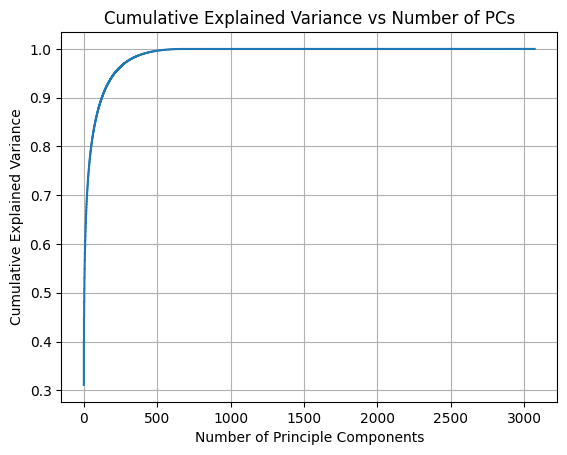

In [79]:
# plotting the relation between cumulative explained variance and number of Pronciple components


# calculating total number of features
m = len(e_vals)

# calculating explained variance for the given eigen values
exp_var = np.empty(m)
for i in range(len(e_vals)):
    ev = e_vals[i]/np.sum(e_vals)
    exp_var[i] = ev

# calculating cumulative explained variance
cum_exp_var = np.cumsum(exp_var)

# plotting the results
plt.step(range(0,len(cum_exp_var)), cum_exp_var)
plt.ylabel('Cumulative Explained Variance')
plt.xlabel('Number of Principle Components')
plt.grid(True)
plt.title('Cumulative Explained Variance vs Number of PCs')
plt.show()


### Finding out performance by taking top k Principle components

In [80]:
k = 1000
eigen_values = e_vals[:k]
eigen_vectors = e_vects[:k]

X_new = np.dot(X_std, eigen_vectors.T)


In [81]:
X_train, X_test, y_train, y_test = train_test_split(X_new,y,test_size=0.2,random_state=32)

t_start = time.time()
model = LogisticRegression(max_iter=2000)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
t_end = time.time()
print(classification_report(y_test,y_pred,zero_division=1))
accuracy_pca = accuracy_score(y_test, y_pred)
print('\n\nAccuracy : ',accuracy_pca)
print('Inference Time : ',np.round(t_end-t_start,2),' sec')


              precision    recall  f1-score   support

           0       0.27      0.75      0.40         4
           1       0.67      0.40      0.50        15
           2       0.46      0.35      0.40        17
           3       0.36      0.53      0.43        17
           4       0.50      0.53      0.51        19
           5       0.75      0.65      0.70        23
           6       0.83      0.94      0.88        16
           7       0.63      0.50      0.56        24

    accuracy                           0.56       135
   macro avg       0.56      0.58      0.55       135
weighted avg       0.59      0.56      0.57       135



Accuracy :  0.562962962962963
Inference Time :  1.81  sec


### Plotting the graph of Accuracy vs Number of PCs

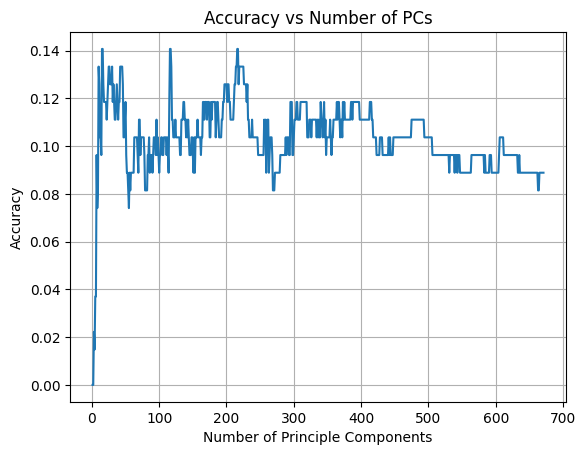

In [82]:
# plotting the graph of accuracy vs number of PCs

acc = []
k_val = []

for k in range(1,672):
    
    eigen_values = e_vals[:k]
    eigen_vectors = e_vects[:k]

    X_new = np.dot(X_std, eigen_vectors.T)
    X_train, X_test, y_train, y_test = train_test_split(X_new,y,test_size=0.2,shuffle=False)

    model = LogisticRegression(max_iter=2000)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    # print(classification_report(y_test,y_pred,zero_division=1))
    accuracy = accuracy_score(y_test, y_pred)
    acc.append(accuracy)
    k_val.append(k)
    
plt.plot(k_val, acc)

# Add labels and a title
plt.xlabel('Number of Principle Components')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of PCs')
plt.grid()
# Show the plot
plt.show()




### Performing dimensionality reduction on assignment 1 features

In [63]:
# performing PCA on the assignment 1 dataset features data.npy

data = np.load('./assignment_1_dataset/data.npy', allow_pickle=True)
y = data[:,3]
print('shape of output = ',y.shape)
data = data[:,2:3]
print('shape of X = ',data.shape)

# reshaping data appropriately (taking only VIT embeddings)
data = np.vstack(data[:, 0])




shape of output =  (1500,)
shape of X =  (1500, 1)


In [64]:
# standardizing data for each feature f X[f] = (X[f]-mean[f])/sd[f]
data_std = standardize_data(data)

# # calculating the covariance matridata of data
cov = np.cov(data_std,rowvar=False)

# # finding sorted eigenvalues and corresponding eigenvectors of S=datadatat
e_vals, e_vects = getEigen(cov)


In [73]:
k = 14 # reducing number of features to 14
eigen_values = e_vals[:k]
eigen_vectors = e_vects[:k]

data_new = np.dot(data_std, eigen_vectors.T)


In [74]:
# calculating metrics for the assignment 1 features reduced to  14
X_train, X_test, y_train, y_test = train_test_split(data_new,y,test_size=0.2,random_state=32)

t_start = time.time()
model = LogisticRegression(max_iter=2000)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
t_end = time.time()
# report = (classification_report(y_test,y_pred,zero_division=1))
accuracy_pca = accuracy_score(y_test, y_pred)
# print('\n\nAccuracy : ',accuracy_pca)

acc = round(accuracy_score(y_test, y_pred),3)

prec_wt = round(precision_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred), zero_division=1),3)
recall_wt = round(recall_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred), zero_division=1),3)
f1_wt = round(f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred), zero_division=1),3)

prec_mi = round(precision_score(y_test, y_pred, average='micro', labels=np.unique(y_pred), zero_division=1),3)
recall_mi = round(recall_score(y_test, y_pred, average='micro', labels=np.unique(y_pred), zero_division=1),3)
f1_mi = round(f1_score(y_test, y_pred, average='micro', labels=np.unique(y_pred), zero_division=1),3)

prec_ma = round(precision_score(y_test, y_pred, average='macro', labels=np.unique(y_pred), zero_division=1),3)
recall_ma = round(recall_score(y_test, y_pred, average='macro', labels=np.unique(y_pred), zero_division=1),3)
f1_ma = round(f1_score(y_test, y_pred, average='macro', labels=np.unique(y_pred), zero_division=1),3)

print('_________________________________________')
print('Accuracy = '+str(acc))
print('_________________________________________')
print('     \t\tmicro\tmacro\tweighted')
print('prec\t\t',str(prec_mi),'\t',str(prec_ma),'\t',str(prec_wt))
print('recall\t\t',str(recall_mi),'\t',str(recall_ma),'\t',str(recall_wt))
print('f1\t\t',str(f1_mi),'\t',str(f1_ma),'\t',str(f1_wt))
print('\n\n')

print('inference time : ',np.round(t_end-t_start,2),' sec')



_________________________________________
Accuracy = 0.153
_________________________________________
     		micro	macro	weighted
prec		 0.153 	 0.136 	 0.194
recall		 0.217 	 0.339 	 0.217
f1		 0.18 	 0.662 	 0.744



inference time :  0.64  sec


#### Comparison of Results and Observations

Following is the performance measures for assignment 1 non-reduced dataset : -
Non-vectorized KNN results :
![Alt text](image.png)

- Accuracy reduced to 0.153 from a max accuracy of around 0.20
- However, the the range in which accuracy lies is almost same
- Minimal decrease in accuracy is seen in reduced dimension dataset (dim=14 instead of 512)
- The precision, recall and f1 scores also decreased (in case of micro)
- In case of macro the scores increased by a comparatively larger amount
- The f1 score for weighted shows significant increase from 0.264 to 0.744

- However, the advantage is seen quite clearly as the inference time is decreased greately (due to the decreased dimensions)
- In total, the advantage gained in inference time and storage costs is much compensated by the slight decrease in accuracy.

# Pictionary Dataset (1.2)
## For Drawer Dataset

In [29]:

# performing PCA on Pictionary DAtaset
path = './smai_assignment_pictionary/drawer_attributes.csv'
data = pd.read_csv(path)

feature_columns = data.columns
# Extract the feature columns from the DataFrame
X = data[feature_columns].values  # This converts the DataFrame to a numpy array



In [30]:
# standardizing data for each feature f X[f] = (X[f]-mean[f])/sd[f]
X_std = standardize_data(X)

# calculating the covariance matrix of X
cov = np.cov(X_std,rowvar=False)

# finding sorted eigenvalues and corresponding eigenvectors of S=XXt
e_vals, e_vects = getEigen(cov)


In [31]:
# since we can only draw in 2 dimensions we will consider the first 2 PCs and plot datapoints in that dimension
# this is equivalent to first reducing the dimensions to 2 and the scatter plotting

k = 2
eigen_values = e_vals[:k]
eigen_vectors = e_vects[:k]

X_new = np.dot(X_std, eigen_vectors.T)


In [32]:
print(X_new.shape)

(100, 2)


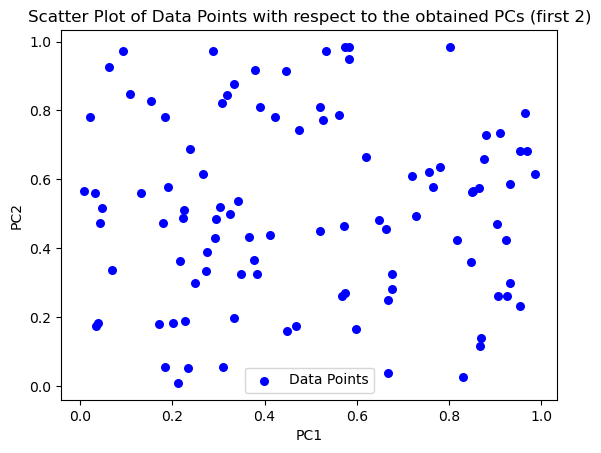

the obtained PC axes are : 
[[ 0.13  0.53  0.52  0.66 -0.    0.   -0.02]
 [-0.5   0.18  0.05 -0.1   0.44  0.27 -0.66]]


In [41]:
X_new = np.random.rand(100, 2)  # Replace this with your actual data

# Extract the x and y coordinates from the array
x_coordinates = X_new[:, 0]
y_coordinates = X_new[:, 1]

# Create a scatter plot
plt.scatter(x_coordinates, y_coordinates, marker='o', s=30, c='b', label='Data Points')

# Add labels and title
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Scatter Plot of Data Points with respect to the obtained PCs (first 2)')

# Show the legend (if you have a label in the scatter plot)
plt.legend()

# Display the plot
plt.show()

print('the obtained PC axes are : ')
print(np.round(eigen_vectors,2))

### What do the new axes represent? (for Drawer Dataset)
- The new axes are the ones which show maximum variance in the dataset

First Principal Component (PC1):

    - PC1 represents the direction in the original feature space along which the data varies the most.
    - It is a linear combination of the original features that explains the largest amount of variance in the data.
    - PC1 captures the primary and dominant patterns or trends in the data. It represents the most critical information that data from each other.

Second Principal Component (PC2):

    - PC2 is orthogonal (perpendicular) to PC1, meaning it represents a direction in the original feature space that is uncorrelated with PC1.
    - It captures the second-largest amount of variance in the data, while still being orthogonal to PC1.
    - PC2 typically captures additional patterns or variations in the data that were not fully explained by PC1. It represents the next most important information in the data.


## For Guesser Dataset

In [35]:

# performing PCA on Pictionary DAtaset
path = './smai_assignment_pictionary/guesser_attributes.csv'
data = pd.read_csv(path)

feature_columns = data.columns
# Extract the feature columns from the DataFrame
X = data[feature_columns].values  # This converts the DataFrame to a numpy array



In [36]:
# standardizing data for each feature f X[f] = (X[f]-mean[f])/sd[f]
X_std = standardize_data(X)

# calculating the covariance matrix of X
cov = np.cov(X_std,rowvar=False)

# finding sorted eigenvalues and corresponding eigenvectors of S=XXt
e_vals, e_vects = getEigen(cov)


In [37]:
# since we can only draw in 2 dimensions we will consider the first 2 PCs and plot datapoints in that dimension
# this is equivalent to first reducing the dimensions to 2 and the scatter plotting

k = 2
eigen_values = e_vals[:k]
eigen_vectors = e_vects[:k]

X_new = np.dot(X_std, eigen_vectors.T)


In [38]:
print(X_new.shape)

(100, 2)


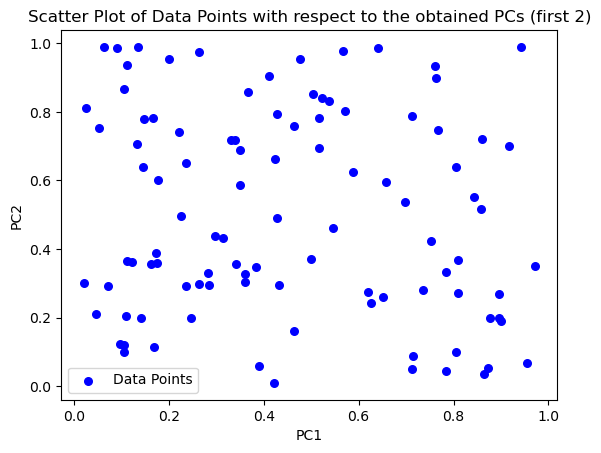

the obtained PC axes are : 
[[ 0.13  0.53  0.52  0.66 -0.    0.   -0.02]
 [-0.5   0.18  0.05 -0.1   0.44  0.27 -0.66]]


In [43]:
X_new = np.random.rand(100, 2)  # Replace this with your actual data

# Extract the x and y coordinates from the array
x_coordinates = X_new[:, 0]
y_coordinates = X_new[:, 1]

# Create a scatter plot
plt.scatter(x_coordinates, y_coordinates, marker='o', s=30, c='b', label='Data Points')

# Add labels and title
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Scatter Plot of Data Points with respect to the obtained PCs (first 2)')

# Show the legend (if you have a label in the scatter plot)
plt.legend()

# Display the plot
plt.show()

print('the obtained PC axes are : ')
print(np.round(eigen_vectors,2))

### What do the new axes represent? (for Drawer Dataset)
- The new axes are the ones which show maximum variance in the dataset

First Principal Component (PC1):

    - PC1 represents the direction in the original feature space along which the data varies the most.
    - It is a linear combination of the original features that explains the largest amount of variance in the data.
    - PC1 captures the primary and dominant patterns or trends in the data. It represents the most critical information that data from each other.

Second Principal Component (PC2):

    - PC2 is orthogonal (perpendicular) to PC1, meaning it represents a direction in the original feature space that is uncorrelated with PC1.
    - It captures the second-largest amount of variance in the data, while still being orthogonal to PC1.
    - PC2 typically captures additional patterns or variations in the data that were not fully explained by PC1. It represents the next most important information in the data.
